## Ultimate Challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
from datetime import datetime, date, timedelta
import calendar
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.font_manager import FontProperties
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
logins = 'logins.json'

logins_df = pd.read_json(logins)
logins_df.head()


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


## Part 1

We were asked to do exploratory analysis of data containing user logins in a particular geographic location and group them based on 15-minute intervals and count them.  Python's grouper function was used to aggregate the data into 15 minute intervals, then for visualization purposes, those data were split into separate dataframes by day and put in order in a list.  In order to visualize them, we overlayed line plots on the same plot if they are from the same weekday/weekend and observed for trends.

From the below plots, we can make a couple of observations:<br>
1. Weekend traffic is much higher between midnight and 5am, and traffic stays low for the rest of the day <br>
2. On weekday's, traffic starts around 630AM and settles down around 1PM, then picks up again around 7PM and keeps the high volume until the next day, dropping slowly until 5AM.
3. There are definite outliers (Red plot on Saturday, Blue plot on Tuesday) which is most likely to be from bad data.

In [4]:
def plot_weekly_plot(day, daily_list):
    '''
    plots by getting data for that given day over weeks
    0 -> Thursday (since 1970/1/1 is a thurday)
    1 -> Friday
    ...
    6 -> Wednesday
    '''
    num_to_day = {0:'Thursday', 1:'Friday', 2:'Saturday', 3:'Sunday',
                  4:'Monday', 5:'Tuesday', 6:'Wednesday'}
    for i in range(day, len(daily_list), 7):
        #strip date from timestamp
        df = daily_list[i]
        date = df.index[0].to_pydatetime()
        date = str(date.year)+'/'+str(date.month)+'/'+str(date.day)
        ser = pd.to_datetime(df.index).to_series()
        df = df.set_index(ser.dt.time)
        if i < 7:
            ax = df.plot(legend=False, rot=45)
        else:
            df.plot(ax=ax, legend=False, rot=45)
    ax.set_title(num_to_day[day])
    ax.set_ylabel('count')
    

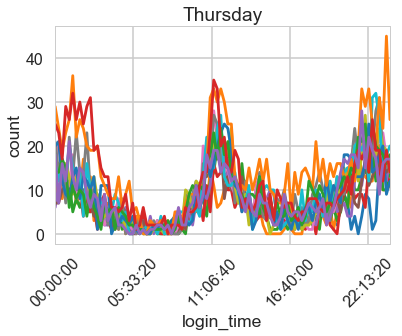

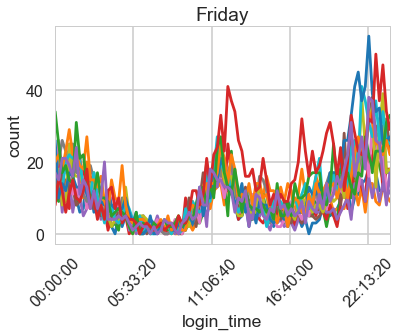

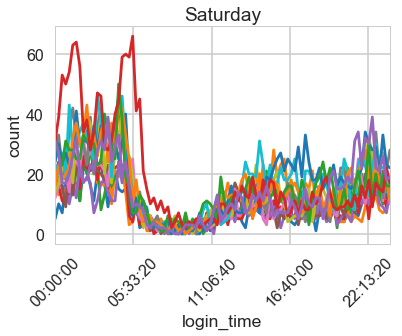

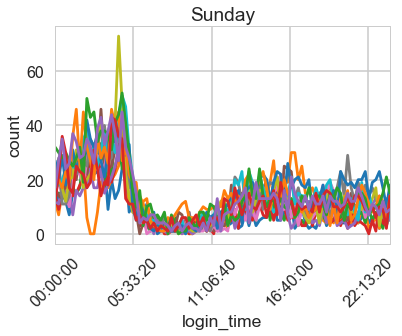

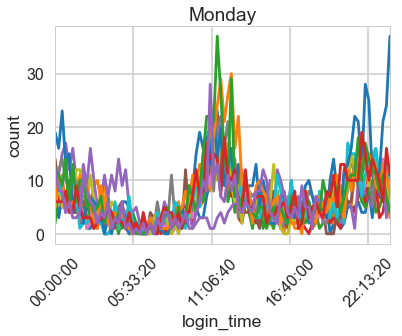

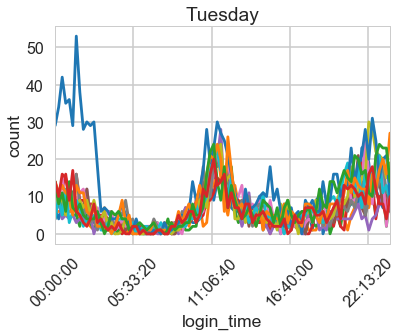

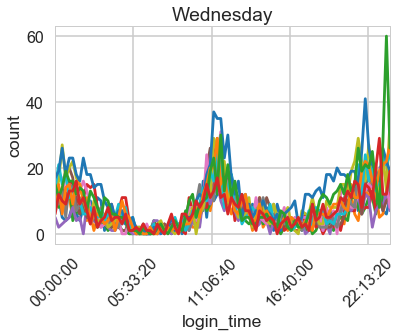

In [5]:
##aggregate by 15 mins
agg_15m = logins_df.reset_index().set_index('login_time')\
            .groupby(pd.TimeGrouper(freq='15Min')).count()

#for easier visualization, plot by week

daily_list = []
for group in agg_15m.groupby(pd.Grouper(freq='D')):
    daily_list.append(group[1])

for i in range(7):
    plot_weekly_plot(i, daily_list)



## Part 2

1. The key measure for this experiment needs to be a metric representing how much commuters came from one city to the other.  Since the current situation of having a two-way toll keeps the drivers exclusive to their own cities, a metric we can use to measure success is the ratio of drivers' activity in both cities.  For example, if a driver does 5 rides in Gotham and 5 rides in Metropolis, this shows that the driver is equally active in both cities, which is what the mayor wants.  Conversely, if a driver is exclusive to one city, or does minimal rides in the other city, the ratio would be much lower.   

2. Before we implement the experiement, we must collect data on a normal week.  We first collect the ratio for each driver before the toll fees are reimbursed.  Then each day we would collect data on the ratio of rides done in each city for each driver.  Once we have enough data collected we can set up a hypothesis test with the below scenario:
   - null hypothesis: There is no difference between the ratios before and after the toll reimbursement program
   - alternate hypothesis: there is significant difference between the ratios<br>

With the new ratios obtained after the program is in place, we can set up a confidence interval and assess if the ratio before the program is within the range of this interval.  If it is not, we can say that there is statistical significance created by this toll reimbursement program

## Part 3 Predicting Rider Retention

Ultimate is interested in predicting rider retention, and in order to do that we perform cleaning, EDA and visualizations of the data here. Each row in the dataset is a driver which contains information of the driver's average rides such as:
- avg_dist
- avg_ratings_by_driver
- avg_rating_of_driver
- avg_surge
- last_trip_date
- sign_up_date

amongst others.  Ultimate also defines a driver has 'active' if they have done a trip in the first 30 days since they signed up.  We check the distributions of the data using boxplots, check sparcity, eliminate null rows and eliminate outliers as much as possible. 


We attempt to remove some of the outliers in below.  However, it was noticed that removing all data which is the top/bottom 2.5% resulted in a dataframe that is < 1% of the original size.  Hence, only the average distance variable was considered, as removing outliers in other columns had too much of an impact in the original dataframe.

In [6]:
import json
data_file = 'ultimate_data_challenge.json'
with open(data_file) as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [7]:
#check for sparcity and the overall spread
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [8]:
#remove null columns
df_filtered = df.dropna(axis=0)
df_filtered.count(), df_filtered.columns

(avg_dist                  41445
 avg_rating_by_driver      41445
 avg_rating_of_driver      41445
 avg_surge                 41445
 city                      41445
 last_trip_date            41445
 phone                     41445
 signup_date               41445
 surge_pct                 41445
 trips_in_first_30_days    41445
 ultimate_black_user       41445
 weekday_pct               41445
 dtype: int64,
 Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
        u'avg_surge', u'city', u'last_trip_date', u'phone', u'signup_date',
        u'surge_pct', u'trips_in_first_30_days', u'ultimate_black_user',
        u'weekday_pct'],
       dtype='object'))

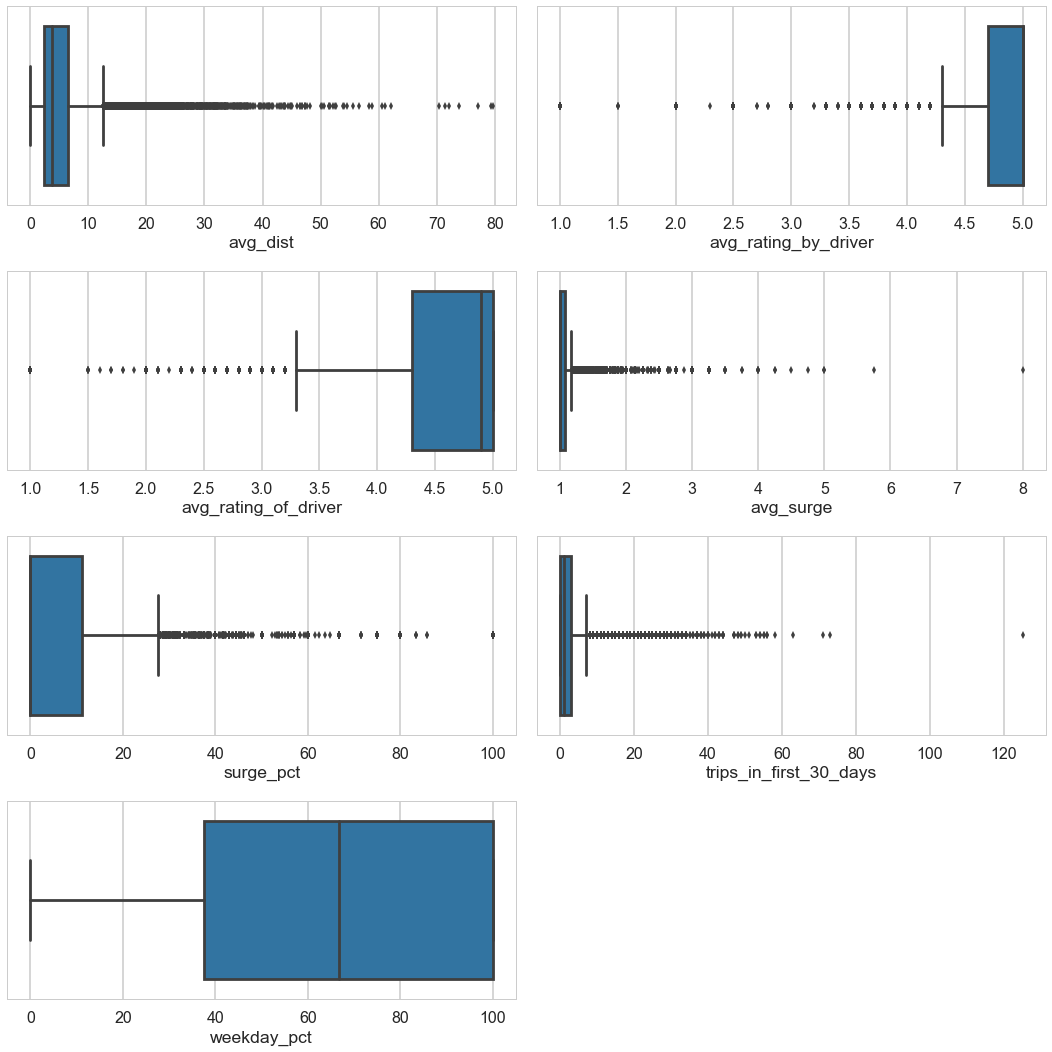

In [9]:
#check outliers by using boxplots. We focus on numerical features of the dataframe

columns = df_filtered.columns
black_list_columns = [u'is_active',           u'city_Astapor',
          u'city_King\'s Landing',        u'city_Winterfell',
                u'phone_Android', 'phone_iPhone', 'ultimate_black_user',
                     'last_trip_date', 'signup_date', 'city', 'phone']
columns = [i for i in columns if i not in black_list_columns]

num_columns = len([i for i in columns if i not in black_list_columns])+1
fig, axes = plt.subplots((num_columns)/2, 2, figsize=(15,15))

for i in range(num_columns):
    col_index = i%2
    row_index = i/2
    
    #in case off number, remove last graph
    try:
        column = columns[i]
    except:
        axes[row_index, col_index].remove()
        break

    sns.boxplot(df_filtered[columns[i]], ax=axes[row_index, col_index])
    #axes[row_index, col_index].boxplot(df_filtered[columns[i]])
    #axes[row_index, col_index].set_title(columns[i])
plt.tight_layout()
plt.show()




In [10]:
#eliminate outliers. 
'''
We attempt to remove some of the outliers in below. 
However, it was noticed that removing all data which is the top/bottom 2.5%
resulted in a dataframe that is < 1% of the original size. Hence, only the
average distance variable was considered, as removing outliers in other 
columns had too much of an impact in the original dataframe.
'''

percentiles_to_keep = 0.25

for column in columns:
    if column in ['avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct',\
                 'trips_in_first_30_days', 'weekday_pct']:
        continue
    print column
    quantiles = np.percentile(df_filtered[column].values, [percentiles_to_keep, 100-percentiles_to_keep])
    print quantiles
    df_filtered = df_filtered[(df_filtered[column] > quantiles[0]) & (df_filtered[column] < quantiles[1])]
    print df_filtered.count()
    print '------------------'


avg_dist
[  3.00000000e-02   3.59256000e+01]
avg_dist                  41234
avg_rating_by_driver      41234
avg_rating_of_driver      41234
avg_surge                 41234
city                      41234
last_trip_date            41234
phone                     41234
signup_date               41234
surge_pct                 41234
trips_in_first_30_days    41234
ultimate_black_user       41234
weekday_pct               41234
dtype: int64
------------------


## Cleaning Results

From cleaning and EDA, we notice that there are a lot of null entries for avg_rating_of_users and some avg_rating_by_driver.  We filter these out and end up with 41234 rows out of the original 50000, which is roughly 82% of the original dataframe.
In terms of outliers, we noticed some but removing those would have too big of an impact on the dataframe. Hence we will keep it as is and continue with the next steps.<br>

now we want to create a new column to indicate if a driver was active in the first 30 days. Basically, if the feature trips_in_first_30_days is non-zero, we mark the driver as active by assigning the value 1 in the new column is_active, else tag them with a 0.  Since trips_in_first_30_days is now highly correlated to the is_active column we do not use this in the predictive step and will be removed at a later time.

Also, categorical values in the dataframe will be encoded in a one-hot vector approach so correlation can be tested if drivers in certain cities are more likely to be active. Panda's get_dummies function was used to create these new columns after figuring out which columns are categorical using the select_dtypes function.

In [11]:
#get latest date
dates = df_filtered['last_trip_date'].values
dates[::-1].sort()
recent_date = dates[0]

# def is_active(date):
#     diff_day = datetime.strptime(recent_date,"%Y-%m-%d") - datetime.strptime(date, "%Y-%m-%d")
#     if diff_day < timedelta(days=30): 
#         return True
#     else:
#         return False

def is_active(value):
    if value > 0:
        return 1
    else:
        return 0
    
    
def make_date(date):
    return datetime.strptime(date, "%Y-%m-%d")

mask = df_filtered['trips_in_first_30_days'].apply(is_active)
df_filtered.loc[:,'is_active'] = mask


df_filtered.loc[:,'last_trip_date'] = df_filtered['last_trip_date'].apply(make_date)
df_filtered.loc[:,'signup_date'] = df_filtered['signup_date'].apply(make_date)


In [12]:
#work on changing categorical values to numerical by creating dummy variables
categorical_df = df_filtered.select_dtypes(include=['object'])[['city', 'phone']].copy()

df_filtered = pd.get_dummies(df_filtered, columns=['city', 'phone'])
df_filtered.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,is_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,2014-07-01,2014-01-25,15.4,4,True,46.2,1,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-07-01,2014-01-29,0.0,0,False,50.0,0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-07-01,2014-01-06,0.0,3,False,100.0,1,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-07-01,2014-01-10,20.0,9,True,80.0,1,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-07-01,2014-01-27,11.8,14,False,82.4,1,0,0,1,1,0


## time based analysis

In the following cells, we analyze some of the dates and see if we can find any trends on how long a driver usually stays as part of Ultimate.  We first check if there are certain durations when drivers are more likely to leave the program by using histograms.

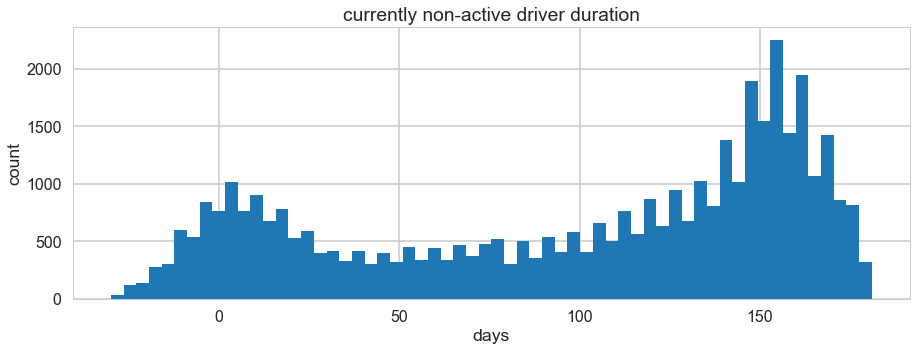

In [13]:
#get the non-active people and check how long they usually last
df_filtered.loc[:, 'length'] = df_filtered['last_trip_date'] - df_filtered['signup_date']
dates_df = df_filtered[['last_trip_date', 'signup_date', 'is_active', 'length']]
dates_df[dates_df['is_active']==False]

durations = [i.days for i in dates_df.length]
plt.figure(figsize=(15,5))
plt.hist(durations, bins=60)
plt.title('currently non-active driver duration')
plt.ylabel('count')
plt.xlabel('days')

we notice above that there are some negative values...which indicates that there are some drivers whose signup_date is later then the last trip date.  Let's filter these out also and remake the histogram.

In [14]:
#remove rows where the signupdate is after the last_trip_date
df_filtered = df_filtered[(df_filtered['last_trip_date']-df_filtered['signup_date']) > timedelta(days=0)]
df_filtered.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,is_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,length
count,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933.000000,37933
mean,5.372992,4.776967,4.601123,1.073885,8.900641,2.618986,61.141199,0.721825,0.325416,0.211109,0.463475,0.290697,0.709303,107 days 16:19:04.164711
std,4.719996,0.398485,0.615380,0.198152,18.259864,4.072973,34.753800,0.448106,0.468536,0.408101,0.498671,0.454090,0.454090,54 days 17:32:18.767827
min,0.040000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1 days 00:00:00
25%,2.430000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63 days 00:00:00
50%,3.790000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,126 days 00:00:00
75%,6.460000,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,154 days 00:00:00
max,35.910000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,181 days 00:00:00


/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


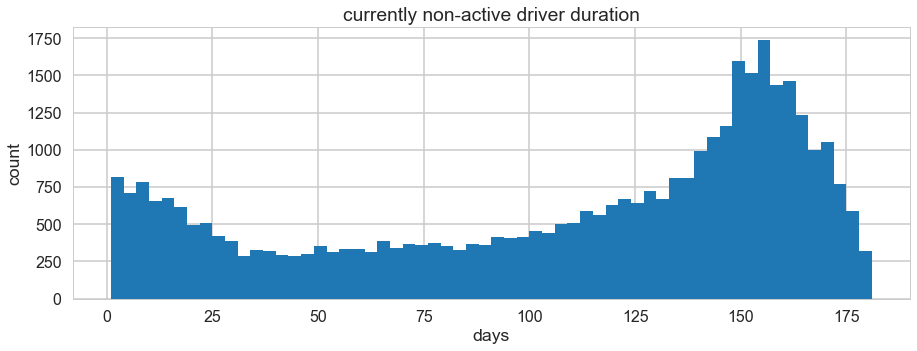

In [15]:
#remake the histogram
dates_df = df_filtered[['last_trip_date', 'signup_date', 'is_active']]
dates_df.loc[:, 'length'] = dates_df['last_trip_date'] - dates_df['signup_date']
dates_df[dates_df['is_active']==False]

durations = [i.days for i in dates_df.length]
plt.figure(figsize=(15,5))
plt.hist(durations, bins=60)
plt.title('currently non-active driver duration')
plt.ylabel('count')
plt.xlabel('days')

Looks better! We see that now there are no one with a negative duration. Here we notice that in the first 25 days, a good number of people stop being active and the rate decreases.  Then it increases around day 100 to a peak at day 150, then again decreases.  this seems like there is some correlation between active users and the duration of their activity.<br>

Below we check correlation between the different dependent variables, and is_active values.  Since is_active was created mainly based off of the trips_in_first_30_days variable, there is high correlation between the two. But also, we find that nothing is clearly highly correlated from this plot.  More detailed analysis through predictive modeling will need to be done.

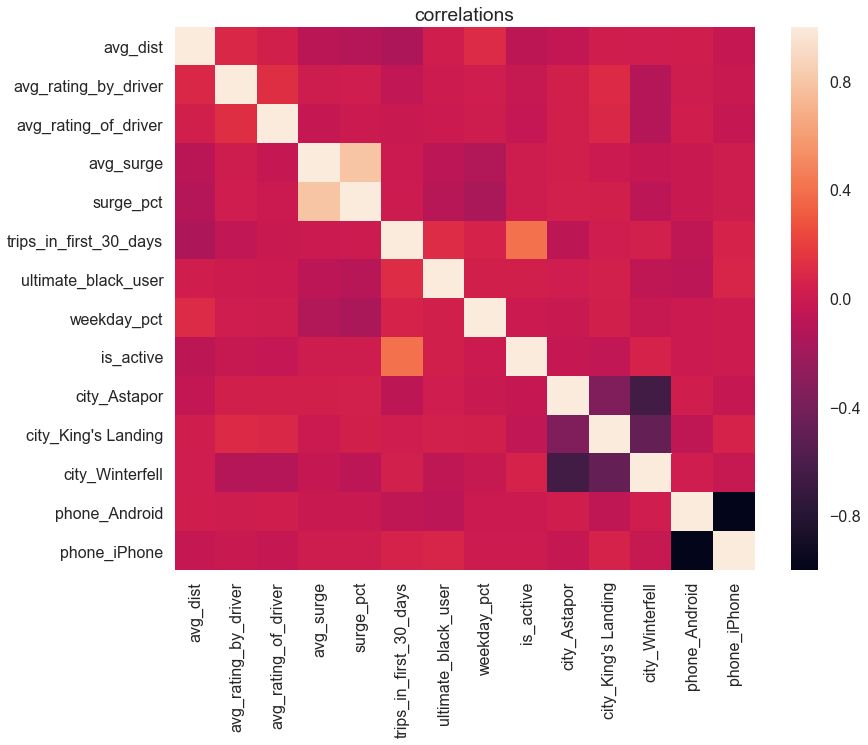

In [16]:
plt.figure(figsize=(13,10))
corr = df_filtered.corr()
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
_ = plt.title('correlations')

In [17]:
#check the raw values of pair wise correlation with is_active
corr['is_active']

avg_dist                 -0.064576
avg_rating_by_driver     -0.021930
avg_rating_of_driver     -0.034795
avg_surge                 0.010622
surge_pct                 0.009093
trips_in_first_30_days    0.399181
ultimate_black_user       0.032273
weekday_pct              -0.005671
is_active                 1.000000
city_Astapor             -0.024261
city_King's Landing      -0.047483
city_Winterfell           0.061654
phone_Android            -0.002017
phone_iPhone              0.002017
Name: is_active, dtype: float64

## Predictive Model Creation

Now that we have a cleaned data and some understanding of it, we continue to create a predictive model to classify whether a user with given features is likely to be an active member or not.  To put more emphasis on interpretability of the model, we focus on using logistic regression initially. We note that there is some class imbalance, where the ratio of inactive to active drivers is roughly 1 to 2.5<br>

Also, we assume that Ultimate's goal is to gain back inactive drivers into active drivers by doing targeted advertising or marketing to define better focus on our goal with predictive modeling.  With this focus, we believe that a recall on inactive drivers is the most important metric when considering the performance of a model.  Of course this doesn't mean to completely ignore precision, so we will create multiple  models with different class weights with oversampled/undersampled/imbalanced datasets and plot a precision-recall curve to find a good balance between precision and recall. So the two most important criterias for our model is:
1. High recall rate for class 0 -> minimize missed opportunities of targeting inactive drivers
2. High precision rate for class 0 -> minimize sending targeted marketing strategy to active drivers


First, we create the the two additional datasets besides the original one.
- The undersampled dataset, where we select a subset of the samples from the majority class so the ending dataset has equivalent amount of class 0 and 1.
- Oversampled dataset using the SMOTE method which synthetically creates new data samples of the minotiry class using KNN. 


In [18]:
#create the train/test dataset from the imbalanced dataset, then create
#oversampled/undersampled dataset from the training set to balance out the training samples
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE

try:
    total_df = df_filtered.drop('length', axis=1).copy()
except:
    pass
targets = total_df['is_active']

#drop columns that adds no value to the dataframe
inputs = total_df.drop(['last_trip_date', 'signup_date', 'is_active', u'trips_in_first_30_days',], axis=1)
inputs = inputs[[u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'surge_pct', 
       u'ultimate_black_user', u'weekday_pct']]

x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, random_state=42)

#make oversampled dataset
x_train_oversampled, y_train_oversampled = SMOTE().fit_sample(x_train,y_train)



In [19]:
x_train.shape, x_test.shape

((26553, 7), (11380, 7))

In [20]:
##check how imbalanced classes are
targets.value_counts()

1    27381
0    10552
Name: is_active, dtype: int64

In [21]:
#check the oversampled population to ensure class counts are the same
pd.Series(y_train_oversampled).value_counts()

1    19181
0    19181
dtype: int64

In [22]:
#make undersampled dataset
under_df =  x_train.copy()
under_df.loc[:,'is_active'] = y_train.copy()

under_df_0s = under_df[under_df['is_active']==0]
under_df_1s = under_df[under_df['is_active']==1]

under_df_1s = under_df_1s.sample(under_df_0s.shape[0])

under_df = under_df_0s.append(under_df_1s)
under_df['is_active'].value_counts()

x_train_under = under_df.drop('is_active', axis=1)
y_train_under = under_df['is_active']


## Dealing with class imbalance
With the three datasets we have, the methodology we use to create the predictive models is as below:

First is to see if we can obtain better recall rates using an oversampled/undersampled dataset.  By keeping the test set as is and training on a balanced dataset, the model should be able to recognize important features and make a better judgement on the prediction.

The second is to use the class_weight parameter which helps emphasize the minority class.  Below we observe the effects of these two approaches

We show the precision and recall rate for each of combination of data input and class_weight , and the precision/recall curve for class 0 with different class weights. 

## Logistic Regression

We first fit the dataset into the logistic regression model to set a baseline accuracy.  Using a vanilla logistic regression with the imbalanced dataset, the overall accuray achieved is 72%, however looking at the recall of the in_active drivers, it did not predict any of the correctly.  The high accuracy was due to class imbalance and the original goal of targeting inactive drivers did not work.  

From the below, it can be observed that any recall above 87% gets a precision rate of 28%, and as recall decreases, precision drastically increases.  If we allow 30% precision, the recall rate goes down to 50%.  From the scatterplots below, we can see that there is a huge decrease in recall with little decrease in precision.  This is not an ideal tradeoff.  We can use this as a baseline and try gradient boosted tree clasifier to see if a better precision/recall rate is feasible.

In [23]:
from sklearn.metrics import classification_report
lr = LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
pred = lr.predict(x_test)
print 'test score is:', lr.score(x_test, y_test)


test score is: 0.720210896309


In [25]:
print classification_report(y_test, pred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3180
          1       0.72      1.00      0.84      8200

avg / total       0.52      0.72      0.60     11380



class 0 precision and recall rates:
weight: 1 precision: 0.316014788869 recall: 0.510691823899
weight: 1.2 precision: 0.285313283208 recall: 0.894968553459
weight: 1.4 precision: 0.279579472559 recall: 0.98679245283
weight: 1.6 precision: 0.279362563832 recall: 0.997798742138
weight: 1.8 precision: 0.279472527473 recall: 0.999685534591
weight: 2 precision: 0.279398839866 recall: 0.999685534591
weight: 3 precision: 0.279437609842 recall: 1.0


/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


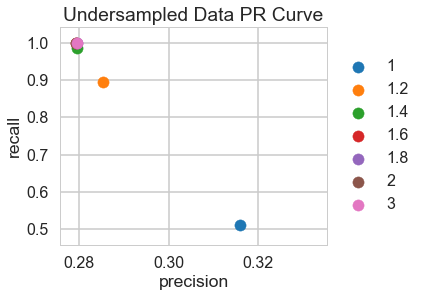

In [26]:
#Undersampled dataset with different class_weights
weights = [1, 1.2, 1.4, 1.6, 1.8, 2, 3]
fig = plt.figure()
ax = plt.subplot(111)
precisions = []
recalls = []
print 'class 0 precision and recall rates:'
for w in weights:
    lr = LogisticRegression(class_weight={0:w, 1:1})
    lr.fit(x_train_under, y_train_under)
    pred = lr.predict(x_test)
    probs = lr.predict_proba(x_test)
    p, r, f1, s = precision_recall_fscore_support(y_test, pred)
    p = p[0]
    r = r[0]
    f1 = f1[0]
    print 'weight:', w, 'precision:', p, 'recall:', r
    #precision, recall, _ = precision_recall_curve(y_test, [i[0] for i in probs])
    #plt.plot(recall, precision)
    plt.scatter(p, r)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(weights, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Undersampled Data PR Curve')
plt.show()
    

weight: 2 precision: 0.382716049383 recall: 0.0974842767296
weight: 3 precision: 0.290272199911 recall: 0.818238993711
weight: 3.2 precision: 0.282406072836 recall: 0.924213836478
weight: 3.4 precision: 0.280510018215 recall: 0.968553459119
weight: 4 precision: 0.279545254252 recall: 0.99748427673


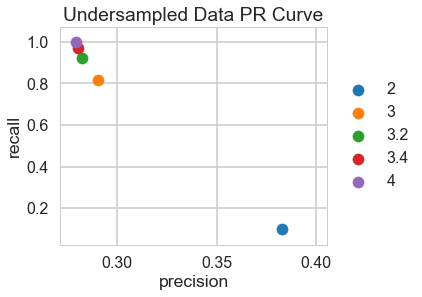

In [27]:
#unbalanced dataset with different class_weights
weights = [2, 3, 3.2, 3.4, 4]
fig = plt.figure()
ax = plt.subplot(111)
precisions = []
recalls = []
for w in weights:
    lr = LogisticRegression(class_weight={0:w, 1:1})
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    probs = lr.predict_proba(x_test)
    p, r, f1, s = precision_recall_fscore_support(y_test, pred)
    p = p[0]
    r = r[0]
    f1 = f1[0]
    print 'weight:', w, 'precision:', p, 'recall:', r

    #precision, recall, _ = precision_recall_curve(y_test, [i[0] for i in probs])
    #plt.plot(recall, precision)
    plt.scatter(p, r)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(weights, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Undersampled Data PR Curve')
plt.show()
    

weight: 1 precision: 0.311171171171 recall: 0.543081761006
weight: 1.2 precision: 0.288413098237 recall: 0.864150943396
weight: 1.4 precision: 0.279688929552 recall: 0.961320754717
weight: 1.6 precision: 0.27921617308 recall: 0.990251572327
weight: 1.8 precision: 0.279227649445 recall: 0.995911949686
weight: 2 precision: 0.279313380282 recall: 0.997798742138
weight: 3 precision: 0.279374285965 recall: 0.999685534591


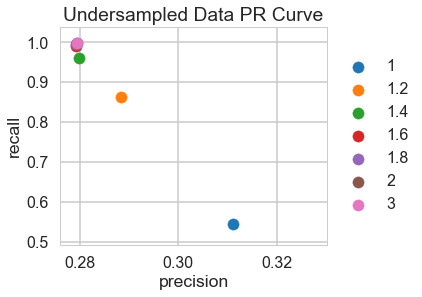

In [28]:
#oversampled dataset with different classweights
weights = [1, 1.2, 1.4, 1.6, 1.8, 2, 3]
fig = plt.figure()
ax = plt.subplot(111)
precisions = []
recalls = []
for w in weights:
    lr = LogisticRegression(class_weight={0:w, 1:1})
    lr.fit(x_train_oversampled, y_train_oversampled)
    pred = lr.predict(x_test)
    probs = lr.predict_proba(x_test)
    p, r, f1, s = precision_recall_fscore_support(y_test, pred)
    p = p[0]
    r = r[0]
    f1 = f1[0]
    print 'weight:', w, 'precision:', p, 'recall:', r

    #precision, recall, _ = precision_recall_curve(y_test, [i[0] for i in probs])
    #plt.plot(recall, precision)
    plt.scatter(p, r)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(weights, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Undersampled Data PR Curve')
plt.show()

## Gradient Boosted Trees

We observer the different recalls and precision ratios achieved using GBC below.  We do the same approach as logistic regressions where we consider the imbalanced/undersampled/oversampled dataset.  For GBC, there is no class_weights option, so we utilize the sample_weight parameter in the fit function.  The sample_weight parameter accepts a list that is the same length as the number of samples where each element is the weight associated with that particular row.  Below, we play around with a number of weights in a for loop, and print out the associated recall and precision rates.  

weight: 1 precision: 0.31914893617 recall: 0.00471698113208
weight: 1.5 precision: 0.412723449001 recall: 0.246855345912
weight: 2 precision: 0.392533220839 recall: 0.585220125786
weight: 2.5 precision: 0.380041724618 recall: 0.687421383648
weight: 3 precision: 0.365853658537 recall: 0.764150943396
weight: 3.5 precision: 0.356380767632 recall: 0.808805031447
weight: 4 precision: 0.348630929425 recall: 0.852830188679


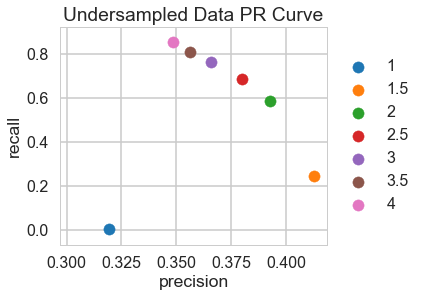

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
weights = [1, 1.5, 2, 2.5, 3, 3.5, 4]

fig = plt.figure()
ax = plt.subplot(111)
for w in weights:
    clf = GradientBoostingClassifier()
    clf.fit(x_train, y_train, \
            sample_weight=[w if i==0 else 1 for i in y_train.values])
    predictions = clf.predict(x_test)
    p, r, f1, s = precision_recall_fscore_support(y_test, predictions)
    p = p[0]
    r = r[0]
    f1 = f1[0]
    print 'weight:', w, 'precision:', p, 'recall:', r
    plt.scatter(p, r)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(weights, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Undersampled Data PR Curve')
plt.show()

weight: 1 precision: 0.373001483435 recall: 0.711635220126
weight: 1.5 precision: 0.350215376583 recall: 0.843710691824
weight: 2 precision: 0.332109670758 recall: 0.910377358491
weight: 2.5 precision: 0.317245005258 recall: 0.948742138365
weight: 3 precision: 0.308201987752 recall: 0.965408805031
weight: 3.5 precision: 0.301618060265 recall: 0.97893081761
weight: 4 precision: 0.296162955945 recall: 0.983018867925


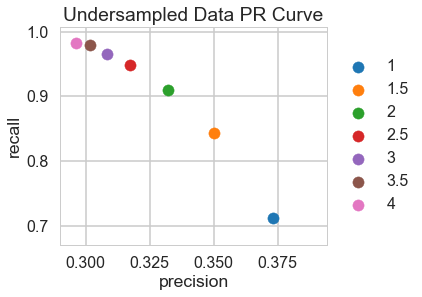

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
weights = [1, 1.5, 2, 2.5, 3, 3.5, 4]
fig = plt.figure()
precisions_under = []
recalls_under = []
ax = plt.subplot(111)
for w in weights:
    clf = GradientBoostingClassifier()
    clf.fit(x_train_under, y_train_under, \
            sample_weight=[w if i==0 else 1 for i in y_train_under.values])
    predictions = clf.predict(x_test)
    #print classification_report(y_test, predictions)
    p, r, f1, s = precision_recall_fscore_support(y_test, predictions)
    p = p[0]
    r = r[0]
    f1 = f1[0]
    print 'weight:', w, 'precision:', p, 'recall:', r
    precisions_under.append(p)
    recalls_under.append(r)
    plt.scatter(p, r)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(weights, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Undersampled Data PR Curve')
plt.show()

weight: 1 precision: 0.390977443609 recall: 0.572327044025
weight: 1.5 precision: 0.370012870013 recall: 0.723270440252
weight: 2 precision: 0.35807181227 recall: 0.796540880503
weight: 2.5 precision: 0.348085658663 recall: 0.843396226415
weight: 3 precision: 0.33764832794 recall: 0.885849056604
weight: 3.5 precision: 0.331045527339 recall: 0.910062893082
weight: 4 precision: 0.323661447498 recall: 0.929559748428


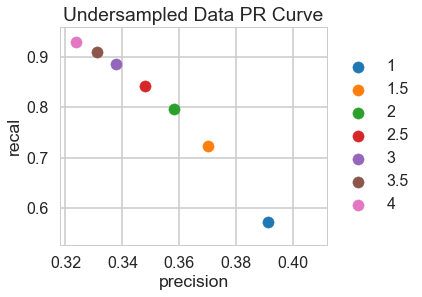

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
weights = [1, 1.5, 2, 2.5, 3, 3.5, 4]
fig = plt.figure()
ax = plt.subplot(111)
precisions_over = []
recalls_over = []
for w in weights:
    
    clf = GradientBoostingClassifier()
    clf.fit(x_train_oversampled, y_train_oversampled, \
            sample_weight=[w if i==0 else 1 for i in y_train_oversampled])
    predictions = clf.predict(x_test)
    #print classification_report(y_test, predictions)
    p, r, f1, s = precision_recall_fscore_support(y_test, predictions)
    p = p[0]
    r = r[0]
    f1 = f1[0]
    print 'weight:', w, 'precision:', p, 'recall:', r
    precisions_over.append(p)
    recalls_over.append(r)
    plt.scatter(p, r)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(weights, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('precision')
plt.ylabel('recal')
plt.title('Undersampled Data PR Curve')
plt.show()

It seems that the recall/precision rates are significantly worse when training the model on the imbalanced dataset.  To differentiate between the accuracies between the undersampled and oversampled data, we overlay the plots with different weights below.  We notice that undersampling is able to achieve a higher recall at the cost of precision, and oversampling is able to achieve a higher precision.  But since these are with the same weights and the curve it follows is very similar, by altering the weights we will most likely be able to match the two graphs identically.  The important fact to notice is a GBC which was trained with undersample/oversampled dataset performs better on the testing set overall

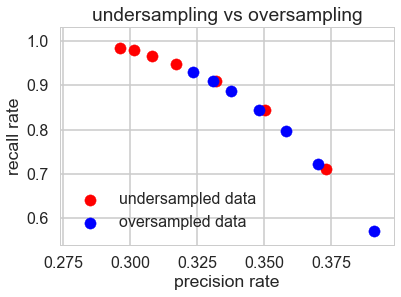

In [32]:
#plot over/under accuracies
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(precisions_under, recalls_under, c='R')
plt.scatter(precisions_over, recalls_over, c='B')
plt.legend(['undersampled data','oversampled data'], loc='lower left')
plt.xlabel('precision rate')
plt.ylabel('recall rate')
plt.title('undersampling vs oversampling')
plt.show()

Below, we note the rough ranges achieved through weight tuning and over/undersampling the dataset for logistic regressions and GBC. <br>

| Algorithm | precision for class 0   | recall for class 0 | 
|-------------|---------------------|------------------|
|      Logistic Regression      |         28%~30%       |      50%~86%       | 
|       Grandient Boosting Classifier     |        30%~38%      |       73%~98%    |

We can see that GBC is able to achieve a much higher accuracy than LR in terms of both precision and recall rate, and the rate at which recall decreases with precision is much less in GBC. Therefore, between the two, I would recommend the use of GBC as a predictive model to analyze which drivers are more likely to be inactive.  The high recall rate GBC can obtain results in less missed opportunities for the business, and the higher the precision rate, less likely it is for active drivers to be tagged as inactive.  <br>

Below, we get the feature_importance attribute from GBC which indicates which features are more important to the target variable, and plot them for a visualization to the business to decide which features to focus on improving.


In [33]:
col_coefficients = zip(clf.feature_importances_, inputs.columns)

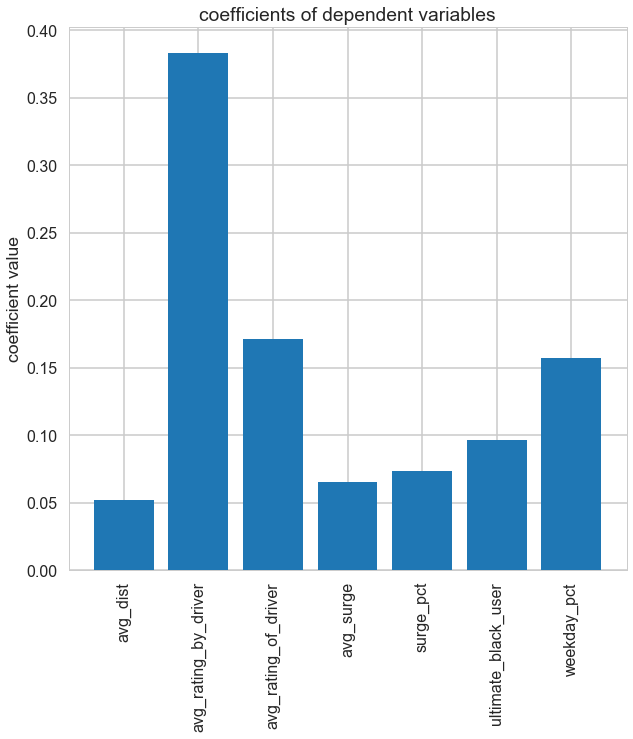

In [34]:
plt.figure(figsize=(10,10))
values = [i[0] for i in col_coefficients]
col_names = [i[1] for i in col_coefficients]
x_s = [i for i in range(len(col_names))]
plt.bar(x_s, values)
plt.xticks(x_s, col_names, rotation=90)
plt.title('coefficients of dependent variables')
plt.ylabel('coefficient value')
_ = plt.show()

From the above it can be seen that there is stronger evidence that users with higher ratings overall tend to have higher likelihood to be an active driver with some emphasis on how much the driver is active on weekdays.  This makes sense as drivers who are active on weekdays probably do not have another job and uses Ultimate as their main form of income, and the higher a driver's rating is, the more passionate they most likely are.

In [35]:
#buffer